# Projeto

## 1. EDA

In [1]:
# Importando as bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import geopandas as gpd
import pickle
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from google.colab import files



In [2]:
# Lendo os dados

data = pd.read_csv('https://raw.githubusercontent.com/pat-weber/lighthouse_cd_2025/main/data/teste_indicium_precificacao.csv')

data.info()

data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [3]:
# Visualizando métricas chave das colunas numéricas

print(data.describe())

                 id       host_id      latitude     longitude         price  \
count  4.889400e+04  4.889400e+04  48894.000000  48894.000000  48894.000000   
mean   1.901753e+07  6.762139e+07     40.728951    -73.952169    152.720763   
std    1.098288e+07  7.861118e+07      0.054529      0.046157    240.156625   
min    2.595000e+03  2.438000e+03     40.499790    -74.244420      0.000000   
25%    9.472371e+06  7.822737e+06     40.690100    -73.983070     69.000000   
50%    1.967743e+07  3.079553e+07     40.723075    -73.955680    106.000000   
75%    2.915225e+07  1.074344e+08     40.763117    -73.936273    175.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990  10000.000000   

       minimo_noites  numero_de_reviews  reviews_por_mes  \
count   48894.000000       48894.000000     38842.000000   
mean        7.030085          23.274758         1.373251   
std        20.510741          44.550991         1.680453   
min         1.000000           0.000000         

### Primeira análise


Temos poucos dados ausentes nas colunas referente a nome dos anúncios e nome do anfitrião. As colunas de última avaliação e quantidade de avaliações têm mais entradas de dados ausentes, o que indica que são anúncios novos, que ainda não tiveram reservas.

Nas colunas numéricas podemos identificar a presença de outliers no preço, sendo o máximo cobrado or diária  10mil, sendo que 75% dos imóveis tem diária abaixo de 175.

Também tem pelo menos um anúncio com preço 0, o que pode ser um erro dos dados.

Na coluna de mínimo de noite também há um outlier com 1.250 noites, o que é excessivo se tratando de alugueis de temporada.

Na coluna que indica quantidade de anúncios por host, temos pelo menos um host com 327 anúncios, o que pode indicar uma empresa administradora de anúncios, assim como a quantidade de 58 avaliações por mês, que também se destaca do restante dos dados.

In [4]:
# Calculando o percentil 99% dos valores de preço

price_99 = data['price'].quantile(0.99)

# Filtrando os valores abaixo do perentil 99%, maiores que 0 e minimo de noite para máximo de 90

data_filtered = data[(data['price'] <= price_99)
  & (data['price'] > 0)
  & (data['minimo_noites'] <= 90)
]

# Comparando tamanho da amostra dos dados após filtro

print(f"Tamanho original: {data.shape}")
print(f"Tamanho filtrado: {data_filtered.shape}")



Tamanho original: (48894, 16)
Tamanho filtrado: (48225, 16)


In [5]:
# Visualizando os dados filtrados

print(data_filtered.describe())

                 id       host_id      latitude     longitude         price  \
count  4.822500e+04  4.822500e+04  48225.000000  48225.000000  48225.000000   
mean   1.902982e+07  6.764738e+07     40.728879    -73.951871    137.578269   
std    1.096974e+07  7.858115e+07      0.054621      0.046201    103.813364   
min    2.595000e+03  2.438000e+03     40.499790    -74.244420     10.000000   
25%    9.486961e+06  7.847292e+06     40.689940    -73.982800     69.000000   
50%    1.969324e+07  3.090988e+07     40.722870    -73.955450    105.000000   
75%    2.913398e+07  1.074344e+08     40.763160    -73.935860    175.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990    799.000000   

       minimo_noites  numero_de_reviews  reviews_por_mes  \
count   48225.000000       48225.000000     38484.000000   
mean        6.100861          23.459098         1.378407   
std         9.811348          44.724189         1.683884   
min         1.000000           0.000000         

A coluna de preço tem agora 799 como valor máximo de diária.
A média que antes era 152 passou para 137, o que significa que filtramos os outliers.
Mínimo de noites tem valor máximo de 90, o que está mais de acordo com aluguéis de temporada.


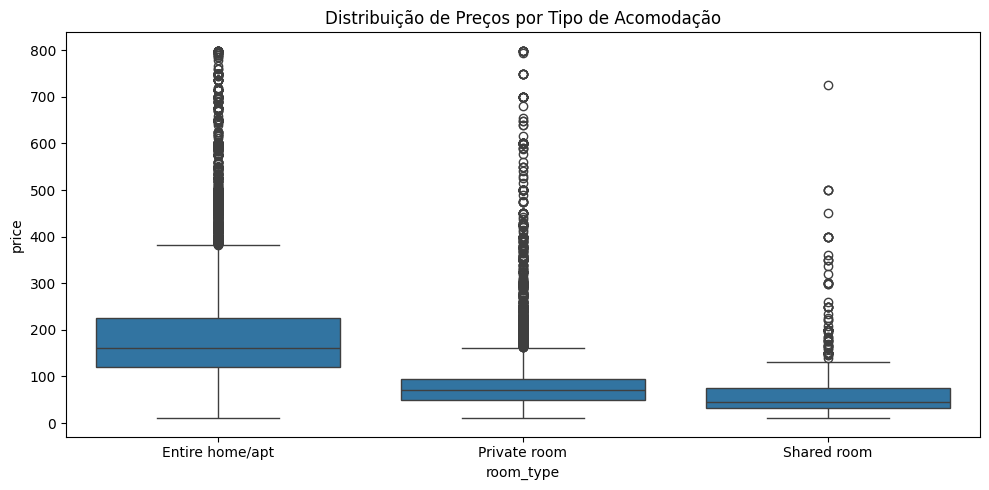

In [6]:
# Visualizando a distribuição de preços por tipo de acomodação

plt.figure(figsize=(10, 5))
sns.boxplot(x='room_type', y='price', data=data_filtered)
plt.title('Distribuição de Preços por Tipo de Acomodação')
plt.tight_layout()

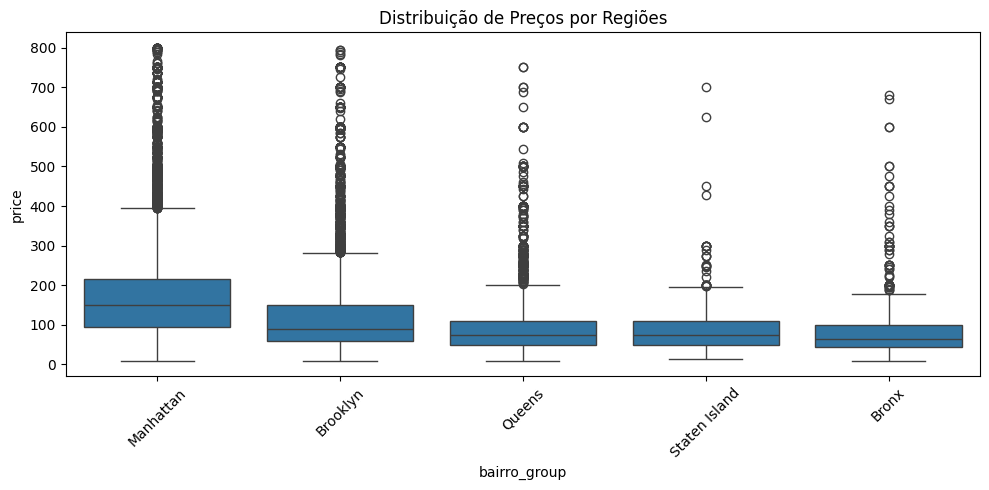

In [7]:
# Visualizando a distribuição de preços por regiões

plt.figure(figsize=(10, 5))
sns.boxplot(x='bairro_group', y='price', data=data_filtered)
plt.title('Distribuição de Preços por Regiões')
plt.xticks(rotation=45)
plt.tight_layout()

<Figure size 1000x500 with 0 Axes>

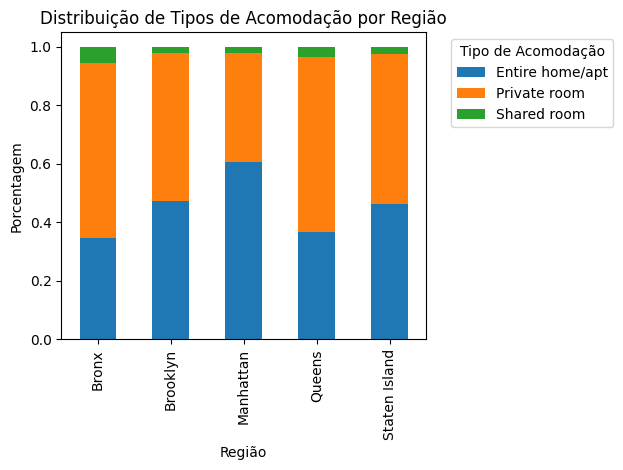

In [8]:
# Visualizando a distribuição de tipos de acomodações por região

plt.figure(figsize=(10, 5))
data_grouped = data_filtered.groupby(['bairro_group', 'room_type']).size().unstack()
data_grouped_percentage = data_grouped.div(data_grouped.sum(axis=1), axis=0)

data_grouped_percentage.plot(kind='bar', stacked=True)
plt.title('Distribuição de Tipos de Acomodação por Região')
plt.xlabel('Região')
plt.ylabel('Porcentagem')
plt.legend(title='Tipo de Acomodação', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

### Segunda análise

Comparando os preços por tipos de anúncios e por regiões, vemos que espaços inteiros são mais caros, Manhattan tem maior quantidade de espaços inteiros e também valores mais altos de diárias.

In [9]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48225 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48225 non-null  int64  
 1   nome                           48210 non-null  object 
 2   host_id                        48225 non-null  int64  
 3   host_name                      48204 non-null  object 
 4   bairro_group                   48225 non-null  object 
 5   bairro                         48225 non-null  object 
 6   latitude                       48225 non-null  float64
 7   longitude                      48225 non-null  float64
 8   room_type                      48225 non-null  object 
 9   price                          48225 non-null  int64  
 10  minimo_noites                  48225 non-null  int64  
 11  numero_de_reviews              48225 non-null  int64  
 12  ultima_review                  38484 non-null  obje

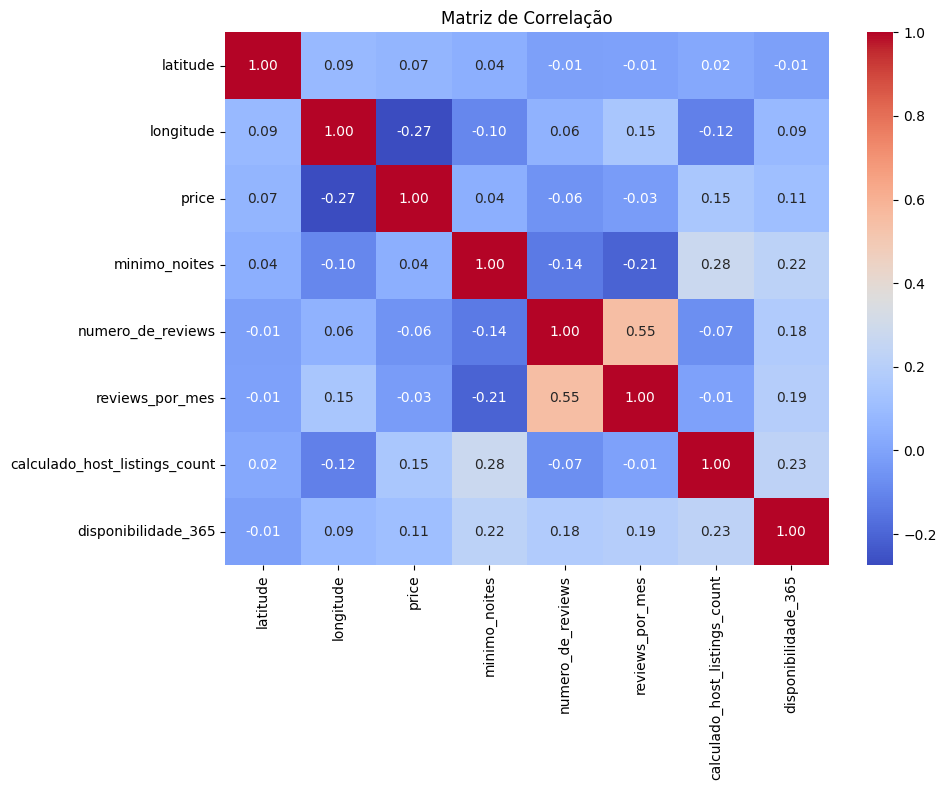

In [10]:
# Visualizando a matriz de correlação

data_filtered_corr = data_filtered.drop(columns=["id", "nome", "host_id", "host_name", "ultima_review", "bairro", "bairro_group", "room_type"])

correlation_matrix = data_filtered_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.tight_layout()
plt.show()


### Análise de correlações

Número de avaliações total e número de avaliações por mês são as únicas correlações fortes, o que não é nada além do esperado para essas duas características.

No mais, podemos ver alguma relação entre avaliações por mês e mínimo de noites e longitude e preço, mas não latitude.

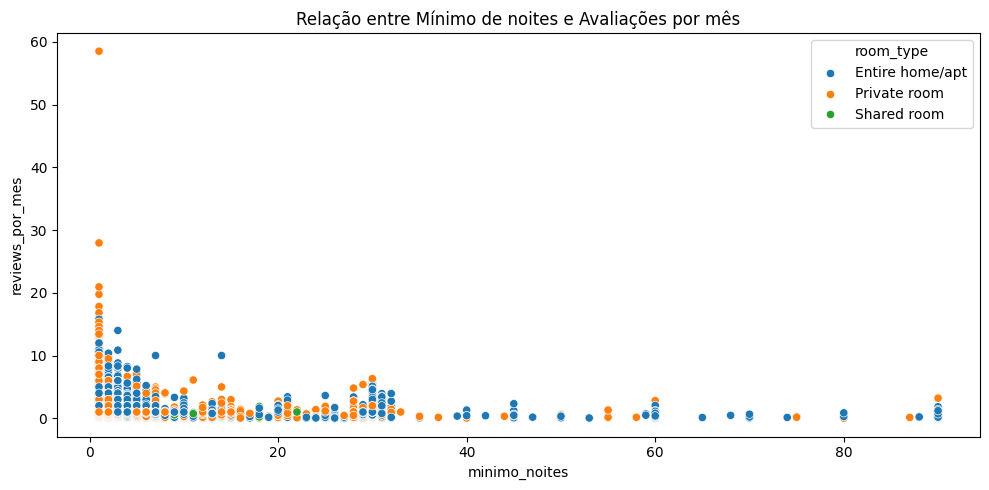

In [11]:
# Visualizando a relação entre minimo de noites e avaliações por mês

plt.figure(figsize=(10, 5))
sns.scatterplot(x='minimo_noites', y='reviews_por_mes', hue='room_type', data=data_filtered)
plt.title('Relação entre Mínimo de noites e Avaliações por mês')
plt.tight_layout()


Realmente existe um padrão que anúncios com maior número de noite para estadia mínima, recebem menos avaliações por mês. O que também é esperado.

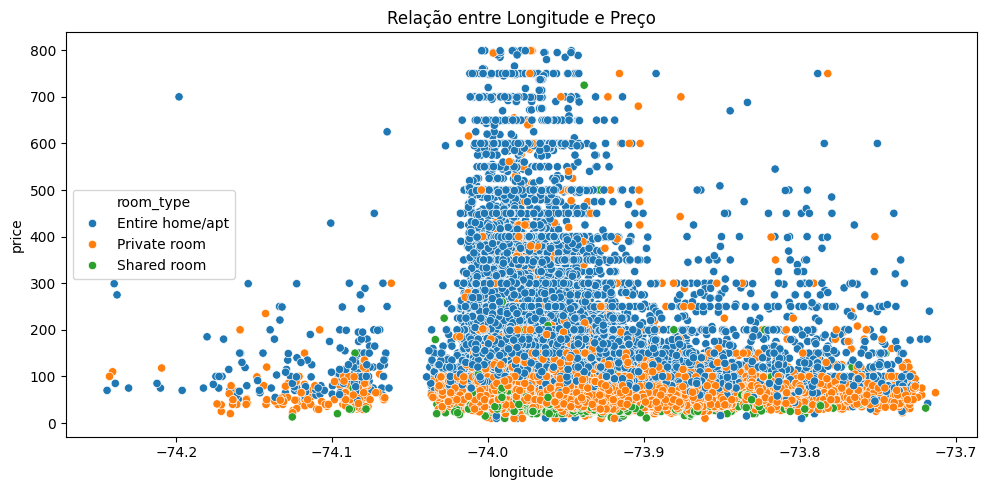

In [12]:
# Visualizando a relação entre longitude e preço

plt.figure(figsize=(10, 5))
sns.scatterplot(x='longitude', y='price', hue='room_type', data=data_filtered)
plt.title('Relação entre Longitude e Preço')
plt.tight_layout()

A relação entre longitude e preço indica que os anúncios de preço mais elevado estão concentrados em determinada faixa de longitude.

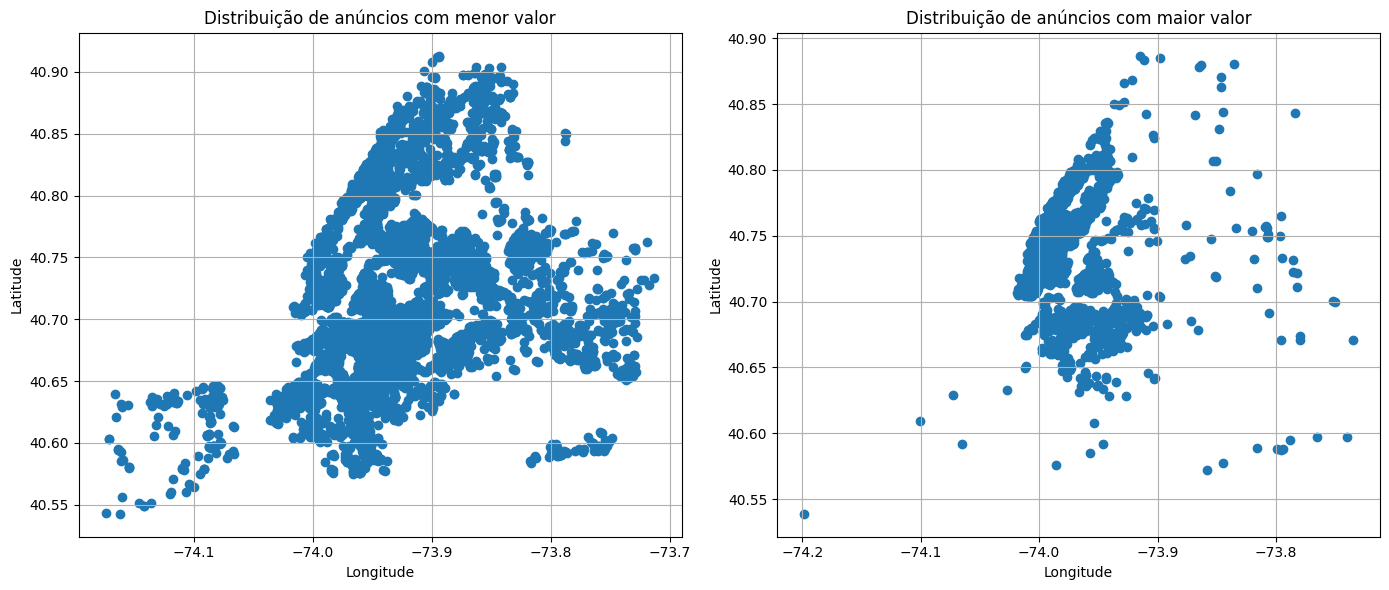

In [13]:
# Selecionando os anúncios do percentil 5% mais caros

price_95 = data_filtered['price'].quantile(0.95)

# Filtrando para mostrar os anúncios com diária abaixo de 70 e os 5% mais caros

data_filtered_below = data_filtered[data_filtered['price'] <=69]
data_filtered_up = data_filtered[data_filtered['price'] >= price_95]

# Visualizando a localização geográfica de cada seleção

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].scatter(data=data_filtered_below, x='longitude', y='latitude')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_title('Distribuição de anúncios com menor valor')
ax[0].grid(True)

ax[1].scatter(data=data_filtered_up, x='longitude', y='latitude')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].set_title('Distribuição de anúncios com maior valor')
ax[1].grid(True)

plt.tight_layout()
plt.show()

Posicionando as coordenadas como em um mapa, é possível perceber que os 5% anúncios de maior preço do nosso dataset já filtrado de outliers se concentram na região de Manhattan, o que já vimos acima no gráfico de dispersão de valores por região.

##  Perguntas

### Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?


Considerando ser uma análise para investidor, selecionamos somente os anúncios de espaço inteiro para analisar, visto que anúncios de quartos privados ou compartilhados são tipicamente de moradores. Seria uma possibilidade criar mais de um anúncio de quartos privados em um mesmo apartamento, mas para essa análise precisaríamos saber quantos quartos tem nos apartamentos. Então vamos filtrar os anúncios de espaço inteiro e trabalhar com esse recorte dos dados.

Também vamos minimizar o impacto de outliers, ignorando valores de diárias e mínimo de noites extremos que já retiramos no dataset 'data_filtered'


In [14]:
# Criando um novo DataFrame contendo apenas os anúncios do tipo 'Entire home/apt'

entire_home_data = data_filtered[data_filtered['room_type'] == 'Entire home/apt']

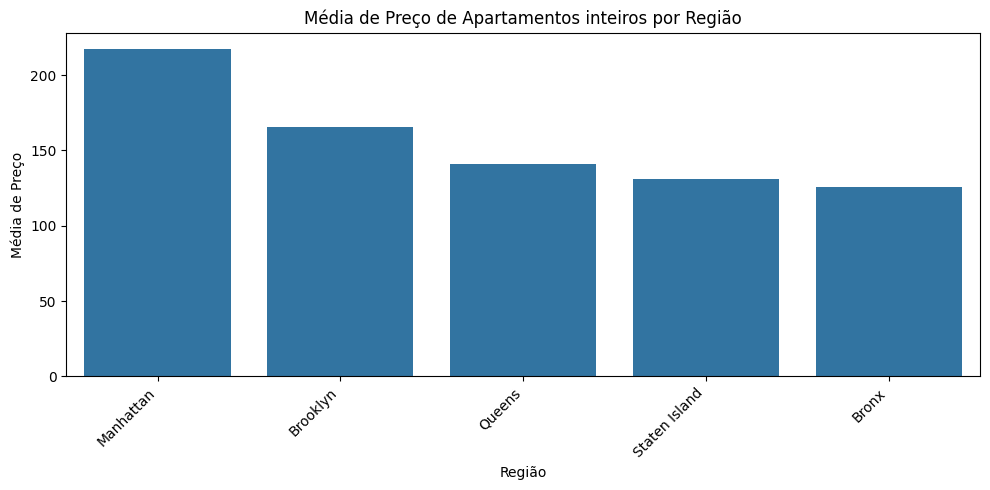

In [15]:
# Visualizando a média de preço por região

# Criando um dataframe com a média de preço por região

average_price_by_region = entire_home_data.groupby('bairro_group')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=average_price_by_region.index, y=average_price_by_region.values)
plt.title('Média de Preço de Apartamentos inteiros por Região')
plt.xlabel('Região')
plt.ylabel('Média de Preço')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

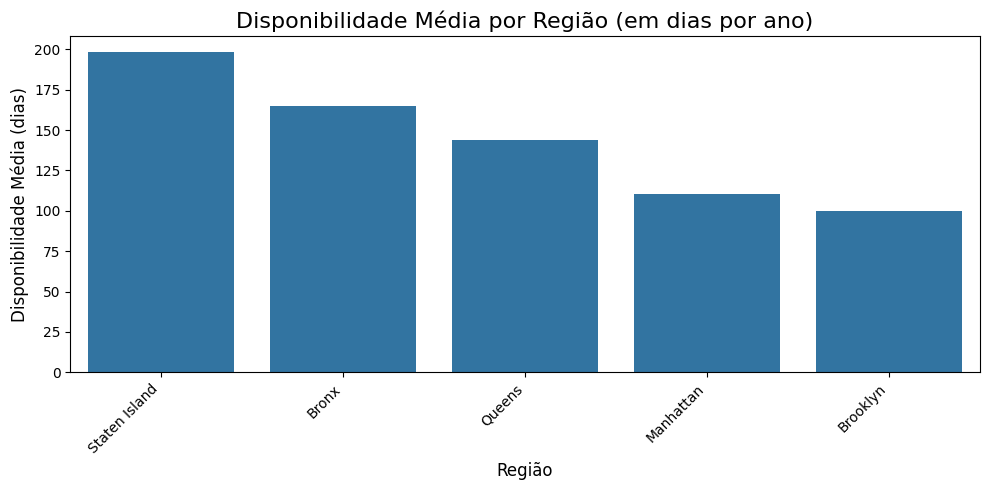

In [16]:
# Visualizando disponibilidade média por região

# Criando um dataframe com a média de disponibilidade por região

availability_by_region = data_filtered.groupby('bairro_group')['disponibilidade_365'].mean().sort_values(ascending=False)


plt.figure(figsize=(10, 5))
sns.barplot(x=availability_by_region.index, y=availability_by_region.values)


plt.title('Disponibilidade Média por Região (em dias por ano)', fontsize=16)
plt.xlabel('Região', fontsize=12)
plt.ylabel('Disponibilidade Média (dias)', fontsize=12)
plt.xticks(rotation=45, ha='right')


plt.tight_layout()

In [17]:
# Criando um dataframe com uma previsão de faturamento


# Calculando ocupação por ano

annual_occupancy_rate = 365 - availability_by_region


# Criando um dataframe com as médias de diária e ocupação por região

regions_df = pd.DataFrame({
    'região': average_price_by_region.index,
    'preço médio': average_price_by_region.values,
    'dias ocupados': annual_occupancy_rate.values
})

regions_df["região"] = regions_df["região"].str.lower()

# Calculando a estimativa de faturamento anual e incluindo no df

regions_df['estimativa faturamento anual'] = regions_df['preço médio'] * regions_df['dias ocupados']


regions_df['preço médio'] = regions_df['preço médio']
regions_df['estimativa faturamento anual'] = regions_df['estimativa faturamento anual']


print(regions_df)


          região  preço médio  dias ocupados  estimativa faturamento anual
0      manhattan   217.267852     166.516304                  36178.639698
1       brooklyn   165.396802     199.762696                  33040.111086
2         queens   140.839097     220.921496                  31114.383961
3  staten island   131.269006     254.759506                  33442.027032
4          bronx   125.468085     265.398385                  33299.027105


Aqui temos uma estimativa de faturamento anual tendo por base de cálculo a média da diária e dias reservados por região. Porém, para indicar um investimento, é preciso também olhar para os custos.

In [18]:
# Lendo dados de real state de Nova York

data_ny_realstate = pd.read_csv('https://raw.githubusercontent.com/pat-weber/lighthouse_cd_2025/main/data/external/NY-House-Dataset.csv')


data.columns = data.columns.str.lower()
data_ny_realstate.columns = data_ny_realstate.columns.str.lower()

data_ny_realstate.info()

data_ny_realstate.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4801 entries, 0 to 4800
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   brokertitle                  4801 non-null   object 
 1   type                         4801 non-null   object 
 2   price                        4801 non-null   int64  
 3   beds                         4801 non-null   int64  
 4   bath                         4801 non-null   float64
 5   propertysqft                 4801 non-null   float64
 6   address                      4801 non-null   object 
 7   state                        4801 non-null   object 
 8   main_address                 4801 non-null   object 
 9   administrative_area_level_2  4801 non-null   object 
 10  locality                     4801 non-null   object 
 11  sublocality                  4801 non-null   object 
 12  street_name                  4801 non-null   object 
 13  long_name         

,brokertitle,type,price,beds,bath,propertysqft,address,state,main_address,administrative_area_level_2,locality,sublocality,street_name,long_name,formatted_address,latitude,longitude
0,Brokered by Douglas Elliman -111 Fifth Ave,Condo for sale,315000,2,2.000000,1400.0,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
1,Brokered by Serhant,Condo for sale,195000000,7,10.000000,17545.0,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991
2,Brokered by Sowae Corp,House for sale,260000,4,2.000000,2015.0,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109
3,Brokered by COMPASS,Condo for sale,69000,3,1.000000,445.0,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613
4,Brokered by Sotheby's International Realty - E...,Townhouse for sale,55000000,7,2.373861,14175.0,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856


Este é um dataset do mercado imobiliário de Nova York, vamos filtrar pelos bairros em comum com nosso dataset de imóveis de temporada para ter valores aproximados do custo de aquisição de um imóvel em cada região.

In [19]:
# Visualizando os bairros e regiões descritos

print(data_ny_realstate['sublocality'].unique())
print()
print(data_ny_realstate['locality'].unique())



['Manhattan' 'New York County' 'Richmond County' 'Kings County' 'New York'
 'East Bronx' 'Brooklyn' 'The Bronx' 'Queens' 'Staten Island'
 'Queens County' 'Bronx County' 'Coney Island' 'Brooklyn Heights'
 'Jackson Heights' 'Riverdale' 'Rego Park' 'Fort Hamilton' 'Flushing'
 'Dumbo' 'Snyder Avenue']

['New York' 'New York County' 'The Bronx' 'Kings County' 'Bronx County'
 'Queens County' 'Richmond County' 'United States' 'Brooklyn' 'Queens'
 'Flatbush']


In [20]:
# Filtrando os bairros compatíveis com nosso dataset

bairros = ['manhattan', 'east bronx', 'the bronx', 'queens county', 'bronx county', 'brooklyn heights', 'queens', 'brooklyn', 'staten island']
sublocality_data = data_ny_realstate[data_ny_realstate['sublocality'].str.lower().isin(bairros)]

replacements = {
    'bronx county': 'bronx',
    'east bronx': 'bronx',
    'the bronx': 'bronx',
    'queens county': 'queens',
    'brooklyn heights': 'brooklyn'
}

sublocality_data['sublocality'] = sublocality_data['sublocality'].str.lower().replace(replacements, regex=True)

# Visualizando métricas básicas da coluna de preço

print(f"Preço mínimo: {sublocality_data['price'].min()}")
print(f"Preço máximo: {sublocality_data['price'].max()}")
print(f"Preço médio: {sublocality_data['price'].mean()}")
print(f"Mediana dos preços: {sublocality_data['price'].median()}")


Preço mínimo: 5800
Preço máximo: 16995000
Preço médio: 836021.3273286468
Mediana dos preços: 600000.0


<ipython-input-20-ad21731d2120>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sublocality_data['sublocality'] = sublocality_data['sublocality'].str.lower().replace(replacements, regex=True)


In [21]:
# Criando um dataframe com os valores medianos de venda de apartamentos em cada uma das regiões

def format_number_with_thousand_separator(number):
    """
    Formata um número com separador de milhares e duas casas decimais.
    """
    return f"{number:,.2f}"

average_price_by_locality = sublocality_data.groupby('sublocality')['price'].median().apply(format_number_with_thousand_separator)

average_price_by_locality = average_price_by_locality.to_frame(name="preço de venda").rename_axis("região").reset_index()

average_price_by_locality


,região,preço de venda
0,bronx,"598,500.00"
1,brooklyn,"558,000.00"
2,manhattan,"2,795,000.00"
3,queens,"669,000.00"
4,staten island,"350,000.00"


In [22]:
# Unindo os dados de faturamento dos imóveis de temporada com os dados de venda de apartamentos

invest_data = regions_df.merge(average_price_by_locality, on="região",  how="left")


invest_data["estimativa faturamento anual"] = (invest_data["estimativa faturamento anual"].astype(float))

invest_data["preço de venda"] = (invest_data["preço de venda"].str.replace(",", "", regex=False).astype(float))

# Calculando o retorno sobre o investimento por ano e quantos anos para o retorno total

invest_data['roi anual (%)'] = (invest_data['estimativa faturamento anual'] / invest_data['preço de venda']) * 100
invest_data['anos para retorno'] = invest_data['preço de venda'] / invest_data['estimativa faturamento anual']
invest_data['ocupação (%)'] = (invest_data['dias ocupados'] / 365) * 100

invest_data = invest_data.sort_values('roi anual (%)', ascending=False)

invest_data


,região,preço médio,dias ocupados,estimativa faturamento anual,preço de venda,roi anual (%),anos para retorno,ocupação (%)
3,staten island,131.269006,254.759506,33442.027032,350000.0,9.554865,10.465873,69.797125
1,brooklyn,165.396802,199.762696,33040.111086,558000.0,5.921167,16.888563,54.729506
4,bronx,125.468085,265.398385,33299.027105,598500.0,5.563747,17.973498,72.711886
2,queens,140.839097,220.921496,31114.383961,669000.0,4.650880,21.501310,60.526437
0,manhattan,217.267852,166.516304,36178.639698,2795000.0,1.294406,77.255530,45.620905


De acordo com as taxas de ocupação e valores das diárias de cada região, além do preço médio de compra de um apartamento, indicamos o investimento na região de Staten Island.

Porém, esse é uma primeira análise e carece de mais dados para poder passar valores mais confiáveis de ROI e anos para retorno.

Ou mesmo explorar outras possibilidades de investimento como por exemplo, um apartamento de dois quartos no Brooklyn e montar 2 anúncios de quartos privados.


### O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

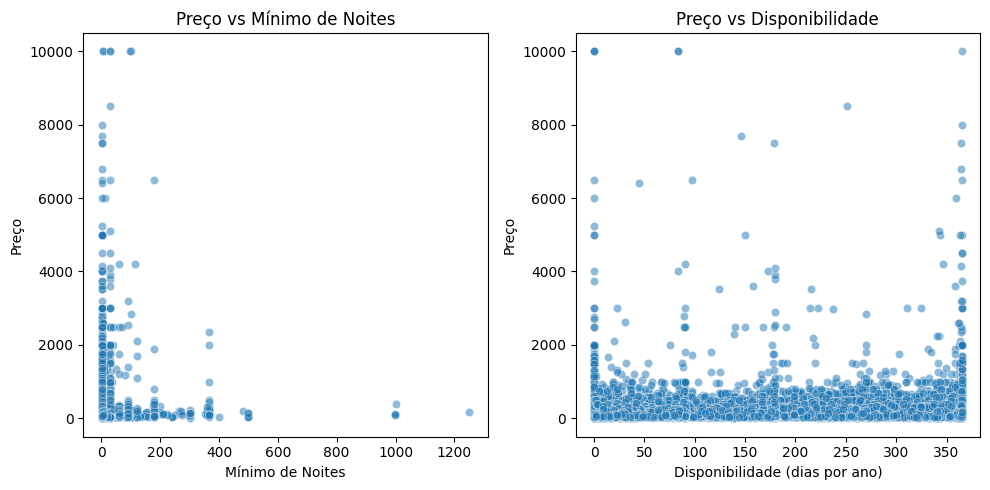

In [23]:
# Visualizando as correlações em gráficos de dispersão

correlations = data[['price', 'minimo_noites', 'disponibilidade_365']].corr()

plt.figure(figsize=(10, 5))

# Plotando gráfico preço vs mínimo de noites

plt.subplot(1, 2, 1)
sns.scatterplot(x='minimo_noites', y='price', data=data, alpha=0.5)
plt.title('Preço vs Mínimo de Noites')
plt.xlabel('Mínimo de Noites')
plt.ylabel('Preço')

# Plotando gráfico de preço vs disponibilidade

plt.subplot(1, 2, 2)
sns.scatterplot(x='disponibilidade_365', y='price', data=data, alpha=0.5)
plt.title('Preço vs Disponibilidade')
plt.xlabel('Disponibilidade (dias por ano)')
plt.ylabel('Preço')

plt.tight_layout()

### Existe algum padrão no texto do nome do local para lugares de mais alto valor?


In [24]:
# Selecionando os 10% anúncios de mais alto valor e exibindo as palavras que mais ocorrem

top_10_percent = data_filtered['price'].quantile(0.9)
data_top_10_percent = data_filtered[data_filtered['price'] >= top_10_percent]

data_top_10_percent['nome'] = data_top_10_percent['nome'].fillna('')

vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(data_top_10_percent['nome'])

tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

word_frequencies = tfidf_df.sum(axis=0).sort_values(ascending=False)

print(word_frequencies.head(20))

<ipython-input-24-f07d5cac5251>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_top_10_percent['nome'] = data_top_10_percent['nome'].fillna('')


bedroom         259.517103
apartment       228.938326
apt             180.675977
village         161.600697
loft            160.768094
luxury          160.193065
spacious        141.688778
manhattan       141.239421
east            140.207465
park            136.921449
west            124.584903
williamsburg    117.995265
nyc             114.183426
heart           110.929100
beautiful       110.632412
midtown         109.385773
brooklyn        109.195693
central         107.005931
modern          106.818629
private         102.699527
dtype: float64


As palavras 'bedroom', 'apartment' ou 'apt' são descrições mais genéricas. Já as que vem em seguida: 'village' e 'loft' desccrevem tipos de imóveis, 'luxury' e 'spacious' descrevem o estilo do imóvel e as palavras seguintes se referem às localidades, dentre as que já vimos que Manhattan é a com maior concentração de diárias mais caras.

Então podemos dizer que um loft espaçoso e com decoração com objetos luxuosos ou que transmitam esse estilo terá diárias mais caras, mas somente.

## Modelo de previsão

In [25]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48225 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48225 non-null  int64  
 1   nome                           48210 non-null  object 
 2   host_id                        48225 non-null  int64  
 3   host_name                      48204 non-null  object 
 4   bairro_group                   48225 non-null  object 
 5   bairro                         48225 non-null  object 
 6   latitude                       48225 non-null  float64
 7   longitude                      48225 non-null  float64
 8   room_type                      48225 non-null  object 
 9   price                          48225 non-null  int64  
 10  minimo_noites                  48225 non-null  int64  
 11  numero_de_reviews              48225 non-null  int64  
 12  ultima_review                  38484 non-null  obje

In [26]:
# Codificando as colunas categóricas

categorical_cols = ["bairro_group", "room_type"]

encoder = OneHotEncoder(sparse_output=False, drop="first")

encoded_array = encoder.fit_transform(data_filtered[categorical_cols])

encoded_data = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols))

data_filtered = pd.concat([data_filtered.drop(columns=categorical_cols), encoded_data], axis=1)


print(data_filtered.info())

<class 'pandas.core.frame.DataFrame'>
Index: 48886 entries, 0 to 48204
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48225 non-null  float64
 1   nome                           48210 non-null  object 
 2   host_id                        48225 non-null  float64
 3   host_name                      48204 non-null  object 
 4   bairro                         48225 non-null  object 
 5   latitude                       48225 non-null  float64
 6   longitude                      48225 non-null  float64
 7   price                          48225 non-null  float64
 8   minimo_noites                  48225 non-null  float64
 9   numero_de_reviews              48225 non-null  float64
 10  ultima_review                  38484 non-null  object 
 11  reviews_por_mes                38484 non-null  float64
 12  calculado_host_listings_count  48225 non-null  floa

Neste modelo vamos priorizar agilidade e não usaremos processamento de texto do nome dos anúncios ou última avaliação, também vamos considerar somente as 5 regiões e não os mais de 200 bairros.

In [27]:
# Desconsiderando as colunas de identificação, última avaliação e bairro.

columns_drop = ["id", "nome", "host_id", "host_name", "ultima_review", "bairro"]

data_filtered_lite = data_filtered.drop(columns=columns_drop)

data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48886 entries, 0 to 48204
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48225 non-null  float64
 1   nome                           48210 non-null  object 
 2   host_id                        48225 non-null  float64
 3   host_name                      48204 non-null  object 
 4   bairro                         48225 non-null  object 
 5   latitude                       48225 non-null  float64
 6   longitude                      48225 non-null  float64
 7   price                          48225 non-null  float64
 8   minimo_noites                  48225 non-null  float64
 9   numero_de_reviews              48225 non-null  float64
 10  ultima_review                  38484 non-null  object 
 11  reviews_por_mes                38484 non-null  float64
 12  calculado_host_listings_count  48225 non-null  floa

Agora vamos testar treinar e avaliar os modelos com dois conjuntos diferentes de dados: um preenchendo com 0 a coluna de avaliações or mês e outro ignorando esses anúncios que ainda não tiveram avaliações.

In [28]:
# Filtrando os dois conjuntos de dados

data_filtered_fill = data_filtered_lite.fillna(0)
data_filtered_drop = data_filtered_lite.dropna()

data_filtered_fill.info()
print()
data_filtered_drop.info()


<class 'pandas.core.frame.DataFrame'>
Index: 48886 entries, 0 to 48204
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   latitude                       48886 non-null  float64
 1   longitude                      48886 non-null  float64
 2   price                          48886 non-null  float64
 3   minimo_noites                  48886 non-null  float64
 4   numero_de_reviews              48886 non-null  float64
 5   reviews_por_mes                48886 non-null  float64
 6   calculado_host_listings_count  48886 non-null  float64
 7   disponibilidade_365            48886 non-null  float64
 8   bairro_group_Brooklyn          48886 non-null  float64
 9   bairro_group_Manhattan         48886 non-null  float64
 10  bairro_group_Queens            48886 non-null  float64
 11  bairro_group_Staten Island     48886 non-null  float64
 12  room_type_Private room         48886 non-null  floa

In [29]:
# Criando uma função para treinar e avaliar modelos

def avaliar_modelos(df, metodo):
    print(f"\n### Avaliação dos modelos ({metodo}) ###")

    X = df.drop(columns=["price"])
    y = df["price"]

    # Divisão dos dados em treino e teste (80% treino, 20% teste)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modelos a serem testados
    modelos = {
        "Random Forest": RandomForestRegressor(random_state=42),
        "XGBoost": XGBRegressor(random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42)
    }

    resultados = {}

    for nome, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)


        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)


        resultados[nome] = {"MAE": mae, "RMSE": rmse, "R²": r2}


        print(f"\nModelo: {nome}")
        print(f"MAE: {mae:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"R²: {r2:.4f}")

    return resultados

resultados_fill = avaliar_modelos(data_filtered_fill, "Preenchendo NaN com 0")

resultados_drop = avaliar_modelos(data_filtered_drop, "Removendo linhas com NaN")



### Avaliação dos modelos (Preenchendo NaN com 0) ###

Modelo: Random Forest
MAE: 55.93
RMSE: 84.58
R²: 0.3519

Modelo: XGBoost
MAE: 55.38
RMSE: 84.31
R²: 0.3561

Modelo: Gradient Boosting
MAE: 57.12
RMSE: 86.91
R²: 0.3158

### Avaliação dos modelos (Removendo linhas com NaN) ###

Modelo: Random Forest
MAE: 54.91
RMSE: 82.14
R²: 0.3336

Modelo: XGBoost
MAE: 54.96
RMSE: 83.34
R²: 0.3140

Modelo: Gradient Boosting
MAE: 56.03
RMSE: 85.16
R²: 0.2837


Os modelos de Floresta Aleatória e XGBoost tiveram desempenhos muito similares nas duas abordagens. Com maior R², o modelo XGBoost que usa os dados ausentes tem uma indicação de conseguir lidar melhor com os dados. Considerando que os valores de erro absoluto de todos não variam muito entre si, vamos explorar mais este modelo.


In [30]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48886 entries, 0 to 48204
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48225 non-null  float64
 1   nome                           48210 non-null  object 
 2   host_id                        48225 non-null  float64
 3   host_name                      48204 non-null  object 
 4   bairro                         48225 non-null  object 
 5   latitude                       48225 non-null  float64
 6   longitude                      48225 non-null  float64
 7   price                          48225 non-null  float64
 8   minimo_noites                  48225 non-null  float64
 9   numero_de_reviews              48225 non-null  float64
 10  ultima_review                  38484 non-null  object 
 11  reviews_por_mes                38484 non-null  float64
 12  calculado_host_listings_count  48225 non-null  floa

In [31]:
# Preparando os dados

columns_drop = ["id", "nome", "host_id", "host_name", "ultima_review", "bairro"]

data_filtered = data_filtered.drop(columns=columns_drop)

data_filtered.fillna(0, inplace=True)

data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48886 entries, 0 to 48204
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   latitude                       48886 non-null  float64
 1   longitude                      48886 non-null  float64
 2   price                          48886 non-null  float64
 3   minimo_noites                  48886 non-null  float64
 4   numero_de_reviews              48886 non-null  float64
 5   reviews_por_mes                48886 non-null  float64
 6   calculado_host_listings_count  48886 non-null  float64
 7   disponibilidade_365            48886 non-null  float64
 8   bairro_group_Brooklyn          48886 non-null  float64
 9   bairro_group_Manhattan         48886 non-null  float64
 10  bairro_group_Queens            48886 non-null  float64
 11  bairro_group_Staten Island     48886 non-null  float64
 12  room_type_Private room         48886 non-null  floa

In [32]:
# Declarando características e divindo conjuntos

X = data_filtered.drop(columns=['price'])
y = data_filtered['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
# Treinando e a valiando o modelo com ajuste de hiperparametros

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")


MAE: 54.81, RMSE: 83.83, R²: 0.3634


In [36]:
# Salvando o modelo

filename = 'xgb_model.pkl'
pickle.dump(xgb_model, open(filename, 'wb'))

files.download(filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
# Predizendo o preço de um novo imóvel

nova_amostra = {
    'latitude': 40.75362,
    'longitude': -73.98377,
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355,
    'bairro_group_Brooklyn': 0,
    'bairro_group_Manhattan': 1,
    'bairro_group_Queens': 0,
    'bairro_group_Staten Island': 0,
    'room_type_Private room': 0,
    'room_type_Shared room': 0
}

df_nova_amostra = pd.DataFrame([nova_amostra])

preco_previsto = xgb_model.predict(df_nova_amostra)[0]

print(f"Preço previsto do aluguel: ${preco_previsto:.2f}")


Preço previsto do aluguel: $179.52


In [35]:
print(average_price_by_region)

bairro_group
Manhattan        217.267852
Brooklyn         165.396802
Queens           140.839097
Staten Island    131.269006
Bronx            125.468085
Name: price, dtype: float64


O valor da diária está um pouco abaixo da média para Manhattan, que é 217. No entanto, este imóvel tem somente 10 dias reservados, faz sentido ser um ajuste de preço de acordo com a disponibilidade.

Ainda assim, informações como número de quartos ou capacidade total de hóspedes seram valiosas para criar modelos mais precisos.